In [1]:
import numpy as np
import torch
from mmdet.models import ResNet
from mmdet.models import Resnet50

import clip

clip.available_models()

model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


/home/work/anaconda3/envs/clip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/work/anaconda3/envs/clip/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/work/workspace/CV/my_mmdet/mmdet/models/backbones/clip.py:25: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")
/home/work/anaconda3/envs/clip/lib/python3.8/site-packages/clip/clip.py:24: UserWarning: PyTorch ver

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

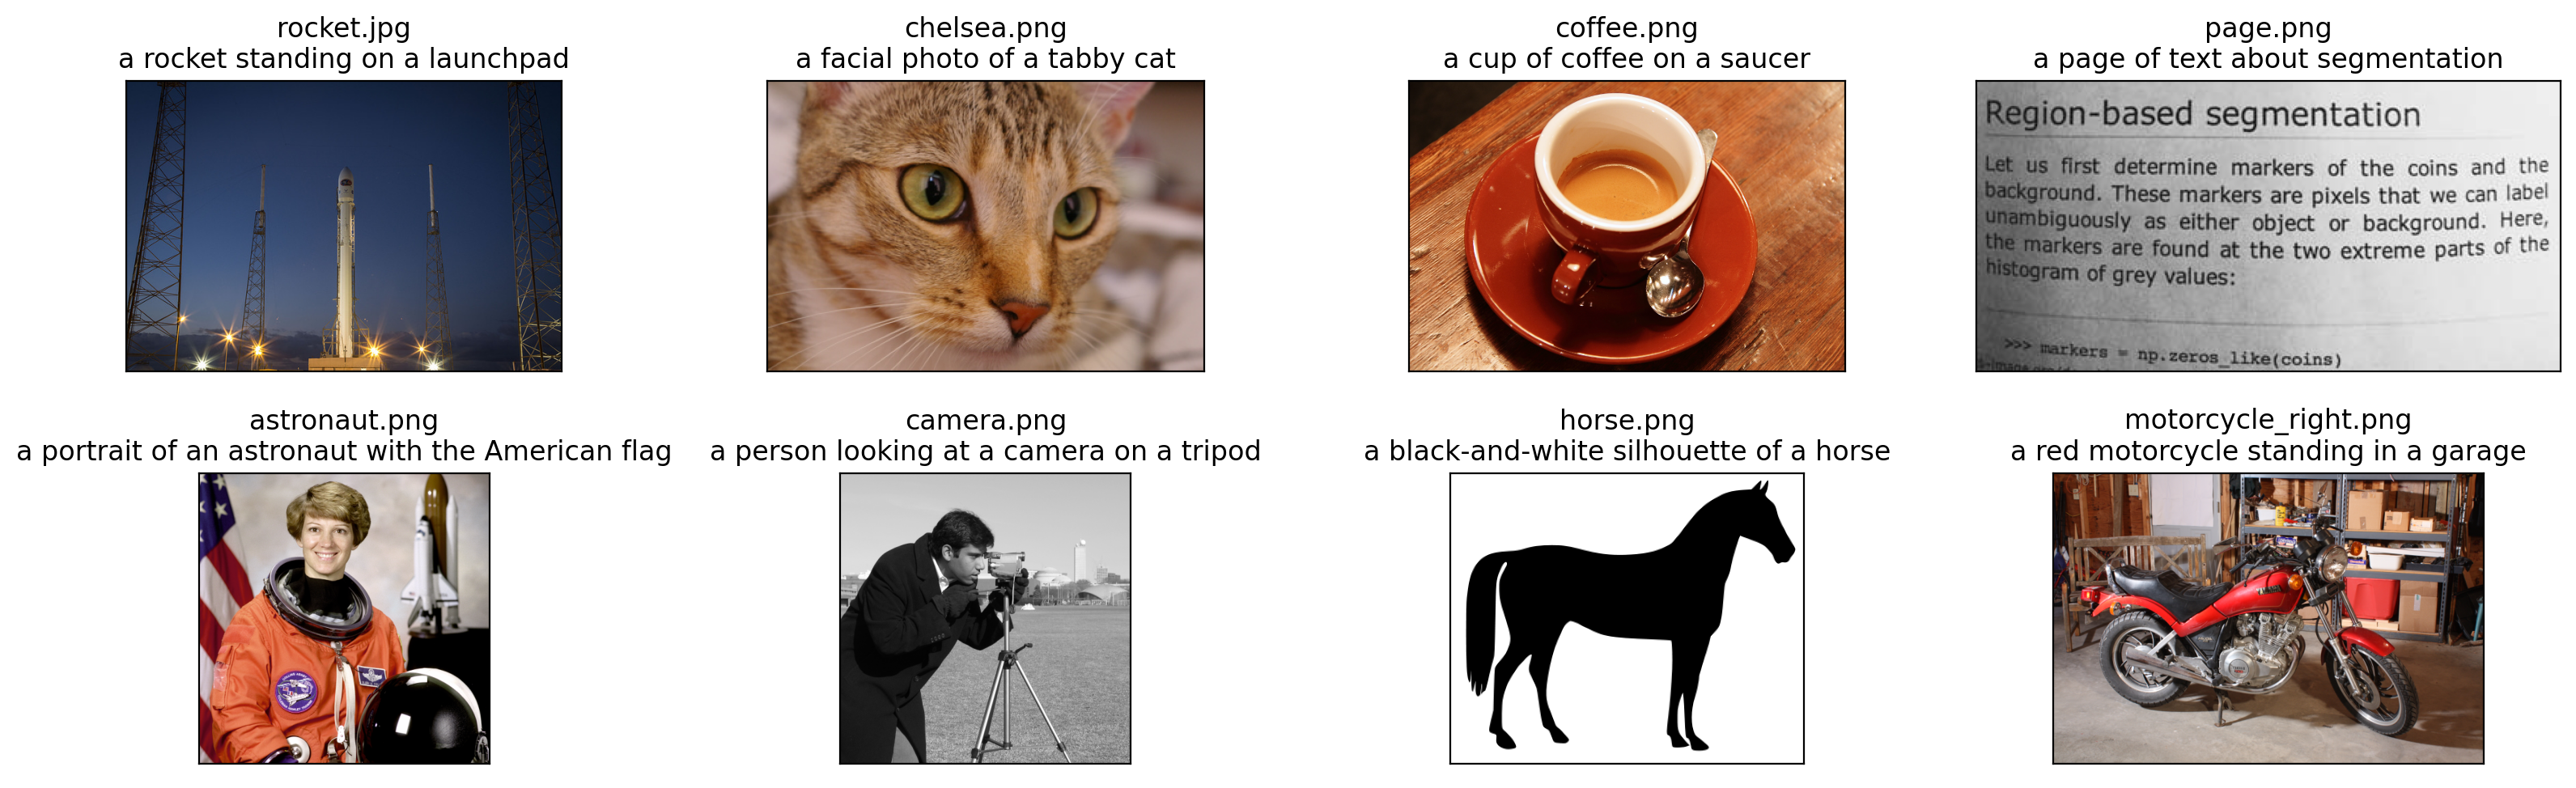

In [3]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [4]:
image_input = torch.tensor(np.stack(images)).cuda()
print(image_input.shape)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

torch.Size([8, 3, 224, 224])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_image_encoder = Resnet50('RN50', device)

In [6]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    print(image_features[0])
print(image_features.shape)
    

tensor([-0.0464, -0.0161,  0.0053,  ..., -0.0501, -0.0970,  0.1377],
       device='cuda:0')
torch.Size([8, 1024])


In [14]:
with torch.no_grad():
    x = image_input.type(model.visual.conv1.weight.dtype)
    x = model.visual.relu1(model.visual.bn1(model.visual.conv1(x)))
    x = model.visual.relu2(model.visual.bn2(model.visual.conv2(x)))
    x = model.visual.relu3(model.visual.bn3(model.visual.conv3(x)))
    x = model.visual.avgpool(x)
    x = model.visual.layer1(x)
    x = model.visual.layer2(x)
    x = model.visual.layer3(x)
    x = model.visual.layer4(x)
    x = model.visual.attnpool(x)
    # image_feature = model.visual.attnpool(top_image_features).float()
    print(x[0].float())



tensor([-0.0467, -0.0164,  0.0048,  ..., -0.0499, -0.0972,  0.1381],
       device='cuda:0')


In [1]:
from mmdet.models.backbones.clip_image import clip_image
import torch.nn as nn
import torch.utils.checkpoint as cp
from mmcv.cnn import build_conv_layer, build_norm_layer, build_plugin_layer

import ipdb
import clip
from mmcv.runner import BaseModule

from torch.nn import functional as F

from collections import OrderedDict
from typing import Tuple, Union

import logging
import torch
import torch.distributed as dist

def print_parameter_grad_info(net):
    print('-------parameters requires grad info--------')
    for name, p in net.named_parameters():
        print(f'{name}:\t{p.requires_grad}')

def print_net_state_dict(net):
    for key, v in net.state_dict().items():
        print(f'{key}')

if __name__ == "__main__":
    # ipdb.set_trace()
    net = clip_image().cuda().float()

    print_parameter_grad_info(net)
    net.requires_grad_(False)
    print_parameter_grad_info(net)

    torch.random.manual_seed(5)
    test_data = torch.rand(1, 3, 1333, 800).cuda()
    train_data = torch.rand(5, 3, 1333, 800).cuda()

    # print(test_data)
    # print(train_data[0, ...])
    for epoch in range(2):
        # training phase, 假设每个epoch只迭代一次
        net.train()
        pre = net(train_data)
        
        net.eval()
        x = net(test_data)
        print(f'epoch:{epoch}', x)



/home/qian/anaconda3/envs/fvlm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/qian/anaconda3/envs/fvlm/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/qian/anaconda3/envs/fvlm/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-------parameters requires grad info--------
clip_model.positional_embedding:	True
clip_model.text_projection:	True
clip_model.logit_scale:	True
clip_model.visual.conv1.weight:	True
clip_model.visual.bn1.weight:	True
clip_model.visual.bn1.bias:	True
clip_model.visual.conv2.weight:	True
clip_model.visual.bn2.weight:	True
clip_model.visual.bn2.bias:	True
clip_model.visual.conv3.weight:	True
clip_model.visual.bn3.weight:	True
clip_model.visual.bn3.bias:	True
clip_model.visual.layer1.0.conv1.weight:	True
clip_model.visual.layer1.0.bn1.weight:	True
clip_model.visual.layer1.0.bn1.bias:	True
clip_model.visual.layer1.0.conv2.weight:	True
clip_model.visual.layer1.0.bn2.weight:	True
clip_model.visual.layer1.0.bn2.bias:	True
clip_model.visual.layer1.0.conv3.weight:	True
clip_model.visual.layer1.0.bn3.weight:	True
clip_model.visual.layer1.0.bn3.bias:	True
clip_model.visual.layer1.0.downsample.0.weight:	True
clip_model.visual.layer1.0.downsample.1.weight:	True
clip_model.visual.layer1.0.downsample.